# Positional Validation


In [1]:
# ruff: noqa: E402

%load_ext autoreload
%autoreload 2

# find the root of the project
import os
from pathlib import Path
import sys
import polars as pl

ROOT = Path(os.getcwd()).parent
while not ROOT.joinpath(".git").exists():
    ROOT = ROOT.parent

# add the root to the python path
sys.path.append(str(ROOT))

SHOW_FIGS = False

## Read the Data


In [2]:
# Length of the GLE

GLE_m = 4.93522
DIST_2_FRONT_m = 2.91
DIST_2_BACK_m = 1.99


veh_df = (
    pl.read_csv(
        ROOT / "data" / "vehicle_drives" / "2023-10-31.csv",
    )
    .drop("")
    .with_columns(
        pl.col("gps_time").str.strptime(
            dtype=pl.Datetime(
                time_unit="us",
            ),
        ),
    )
    .sort(
        "gps_time",
    )
    # .upsample(
    #     "gps_time",
    #     every="100ms",
    # )
    # .sort("gps_time")
    # .with_columns(
    #     pl.col(pl.FLOAT_DTYPES).interpolate(),
    #     pl.col(pl.INTEGER_DTYPES).first(),
    # )
    .with_row_count(name="seq")
)

In [3]:
veh_df.shape

(19612, 5)

### Map to Lanes


In [4]:
import geopandas as gpd
from src.geometry import RoadNetwork


network = RoadNetwork(
    lane_gdf=gpd.read_file(ROOT / "data/mainline_lanes.geojson"),
    step_size=0.1,
)

lane_df = network.df

LANE_WIDTH = 3.5

## Snap the Vehicle Trajectories to Lanes


In [5]:
import utm

x, y, _, _ = utm.from_latlon(
    latitude=veh_df["lat"].to_numpy(),
    longitude=veh_df["lon"].to_numpy(),
)

veh_df = (
    veh_df.with_columns(
        x=x,
        y=y,
    )
    .with_columns(
        (pl.col("x").diff() ** 2 + pl.col("y").diff() ** 2).sqrt().alias("dist"),
    )
    .with_columns(
        (
            pl.col("dist") / (pl.col("gps_time").diff().dt.total_milliseconds() / 1e3)
        ).alias("speed"),
    )
)

veh_df.head()

shape: (5, 9)
┌─────┬───────────────┬───────────┬────────────┬───┬──────────────┬──────────┬──────────┬──────────┐
│ seq ┆ gps_time      ┆ lat       ┆ lon        ┆ … ┆ x            ┆ y        ┆ dist     ┆ speed    │
│ --- ┆ ---           ┆ ---       ┆ ---        ┆   ┆ ---          ┆ ---      ┆ ---      ┆ ---      │
│ u32 ┆ datetime[μs,  ┆ f64       ┆ f64        ┆   ┆ f64          ┆ f64      ┆ f64      ┆ f64      │
│     ┆ UTC]          ┆           ┆            ┆   ┆              ┆          ┆          ┆          │
╞═════╪═══════════════╪═══════════╪════════════╪═══╪══════════════╪══════════╪══════════╪══════════╡
│ 0   ┆ 2023-10-31    ┆ 33.235349 ┆ -87.610211 ┆ … ┆ 443147.97831 ┆ 3.6775e6 ┆ null     ┆ null     │
│     ┆ 16:43:11.400  ┆           ┆            ┆   ┆ 5            ┆          ┆          ┆          │
│     ┆ UTC           ┆           ┆            ┆   ┆              ┆          ┆          ┆          │
│ 1   ┆ 2023-10-31    ┆ 33.235349 ┆ -87.610211 ┆ … ┆ 443147.97869 ┆ 3.6775e6 ┆ 0.000962 ┆ 0.009621 │
│     ┆ 16:43:11.500  ┆           ┆            ┆   ┆ 2            ┆          ┆          ┆          │
│     ┆ UTC           ┆           ┆            ┆   ┆              ┆          ┆          ┆          │
│ 2   ┆ 2023-10-31    ┆ 33.235349 ┆ -87.610211 ┆ … ┆ 443147.97924 ┆ 3.6775e6 ┆ 0.000787 ┆ 0.007873 │
│     ┆ 16:43:11.600  ┆           ┆            ┆   ┆ 8            ┆          ┆          ┆          │
│     ┆ UTC           ┆           ┆            ┆   ┆              ┆          ┆          ┆          │
│ 3   ┆ 2023-10-31    ┆ 33.235349 ┆ -87.610211 ┆ … ┆ 443147.97850 ┆ 3.6775e6 ┆ 0.000816 ┆ 0.008162 │
│     ┆ 16:43:11.700  ┆           ┆            ┆   ┆ 1            ┆          ┆          ┆          │
│     ┆ UTC           ┆           ┆            ┆   ┆              ┆          ┆          ┆          │
│ 4   ┆ 2023-10-31    ┆ 33.235349 ┆ -87.610211 ┆ … ┆ 443147.97897 ┆ 3.6775e6 ┆ 0.000724 ┆ 0.007241 │
│     ┆ 16:43:11.800  ┆           ┆            ┆   ┆              ┆          ┆          ┆          │
│     ┆ UTC           ┆           ┆            ┆   ┆              ┆          ┆          ┆          │
└─────┴───────────────┴───────────┴────────────┴───┴──────────────┴──────────┴──────────┴──────────┘

### Build the KDTree


In [6]:
veh_df = network.map_to_lane(
    veh_df,
    dist_upper_bound=3,
    utm_x_col="x",
    utm_y_col="y",
)

In [7]:
veh_df = (
    veh_df.with_columns(
        pl.col("name").fill_null(""),
    )
    .with_columns(
        (
            (pl.col("name").shift(1) != pl.col("name"))
            & (pl.col("name").shift(1) != "")
        ).alias("sequence"),
    )
    .with_columns(
        (pl.col("sequence").cum_sum() * (pl.col("name") != "")).alias("sequence_id"),
    )
    .filter(pl.col("sequence_id") != 0)
)

In [8]:
veh_df.head()

shape: (5, 18)
┌──────┬───────────────────┬───────────┬────────────┬───┬──────────┬──────┬──────────┬─────────────┐
│ seq  ┆ gps_time          ┆ lat       ┆ lon        ┆ … ┆ angle    ┆ name ┆ sequence ┆ sequence_id │
│ ---  ┆ ---               ┆ ---       ┆ ---        ┆   ┆ ---      ┆ ---  ┆ ---      ┆ ---         │
│ u32  ┆ datetime[μs, UTC] ┆ f64       ┆ f64        ┆   ┆ f64      ┆ str  ┆ bool     ┆ u32         │
╞══════╪═══════════════════╪═══════════╪════════════╪═══╪══════════╪══════╪══════════╪═════════════╡
│ 1325 ┆ 2023-10-31        ┆ 33.235712 ┆ -87.610401 ┆ … ┆ 0.263532 ┆ EBL2 ┆ true     ┆ 1           │
│      ┆ 16:45:35.200 UTC  ┆           ┆            ┆   ┆          ┆      ┆          ┆             │
│ 1326 ┆ 2023-10-31        ┆ 33.235719 ┆ -87.610401 ┆ … ┆ 0.263532 ┆ EBL2 ┆ false    ┆ 1           │
│      ┆ 16:45:35.300 UTC  ┆           ┆            ┆   ┆          ┆      ┆          ┆             │
│ 1327 ┆ 2023-10-31        ┆ 33.235726 ┆ -87.610401 ┆ … ┆ 0.263532 ┆ EBL2 ┆ false    ┆ 1           │
│      ┆ 16:45:35.400 UTC  ┆           ┆            ┆   ┆          ┆      ┆          ┆             │
│ 1328 ┆ 2023-10-31        ┆ 33.235734 ┆ -87.610402 ┆ … ┆ 0.263532 ┆ EBL2 ┆ false    ┆ 1           │
│      ┆ 16:45:35.500 UTC  ┆           ┆            ┆   ┆          ┆      ┆          ┆             │
│ 1329 ┆ 2023-10-31        ┆ 33.235741 ┆ -87.610402 ┆ … ┆ 0.263532 ┆ EBL2 ┆ false    ┆ 1           │
│      ┆ 16:45:35.600 UTC  ┆           ┆            ┆   ┆          ┆      ┆          ┆             │
└──────┴───────────────────┴───────────┴────────────┴───┴──────────┴──────┴──────────┴─────────────┘

In [9]:
ebl1_df = veh_df.filter(pl.col("sequence_id") == 12).with_columns(
    (
        pl.col("s").diff() / (pl.col("gps_time").diff().dt.total_milliseconds() / 1e3)
    ).alias("speed")
)

In [10]:
ebl1_df.head()

shape: (5, 18)
┌──────┬──────────────────┬───────────┬────────────┬───┬───────────┬──────┬──────────┬─────────────┐
│ seq  ┆ gps_time         ┆ lat       ┆ lon        ┆ … ┆ angle     ┆ name ┆ sequence ┆ sequence_id │
│ ---  ┆ ---              ┆ ---       ┆ ---        ┆   ┆ ---       ┆ ---  ┆ ---      ┆ ---         │
│ u32  ┆ datetime[μs,     ┆ f64       ┆ f64        ┆   ┆ f64       ┆ str  ┆ bool     ┆ u32         │
│      ┆ UTC]             ┆           ┆            ┆   ┆           ┆      ┆          ┆             │
╞══════╪══════════════════╪═══════════╪════════════╪═══╪═══════════╪══════╪══════════╪═════════════╡
│ 8562 ┆ 2023-10-31       ┆ 33.234887 ┆ -87.614469 ┆ … ┆ -2.882174 ┆ WBL2 ┆ false    ┆ 12          │
│      ┆ 16:58:46.600 UTC ┆           ┆            ┆   ┆           ┆      ┆          ┆             │
│ 8563 ┆ 2023-10-31       ┆ 33.234893 ┆ -87.614466 ┆ … ┆ -2.882174 ┆ WBL2 ┆ false    ┆ 12          │
│      ┆ 16:58:46.700 UTC ┆           ┆            ┆   ┆           ┆      ┆          ┆             │
│ 8564 ┆ 2023-10-31       ┆ 33.234898 ┆ -87.614463 ┆ … ┆ -2.882174 ┆ WBL2 ┆ false    ┆ 12          │
│      ┆ 16:58:46.800 UTC ┆           ┆            ┆   ┆           ┆      ┆          ┆             │
│ 8565 ┆ 2023-10-31       ┆ 33.234903 ┆ -87.614461 ┆ … ┆ -2.882348 ┆ WBL2 ┆ false    ┆ 12          │
│      ┆ 16:58:46.900 UTC ┆           ┆            ┆   ┆           ┆      ┆          ┆             │
│ 8566 ┆ 2023-10-31       ┆ 33.234908 ┆ -87.614459 ┆ … ┆ -2.882534 ┆ WBL2 ┆ false    ┆ 12          │
│      ┆ 16:58:47 UTC     ┆           ┆            ┆   ┆           ┆      ┆          ┆             │
└──────┴──────────────────┴───────────┴────────────┴───┴───────────┴──────┴──────────┴─────────────┘

## Read in the Trajectories


In [11]:
from datetime import timedelta
import polars as pl
from src.radar import CalibratedRadar
from src.pipelines.open_file import prep_df


# make a consolidated network with only EBL1 and WBL1

mainline_net = RoadNetwork(
    lane_gdf=gpd.read_file(ROOT / "data/mainline_lanes.geojson"),
    keep_lanes=["EBL1", "WBL1"],
    step_size=0.1,
)

full_net = RoadNetwork(
    lane_gdf=gpd.read_file(ROOT / "data/mainline_lanes.geojson"),
    keep_lanes=["EBL1", "EBL2", "WBL1", "WBL2"],
    step_size=0.1,
)

radar_obj = CalibratedRadar(
    radar_location_path=ROOT / "configuration" / "october_calibrated.yaml",
)


radar_df = (
    pl.scan_parquet(
        ROOT.joinpath("data", "raw", "*.parquet"),
    )
    .with_columns(
        pl.col("epoch_time").dt.replace_time_zone("UTC"),
    )
    .with_context(veh_df.lazy())
    .filter(
        pl.col("epoch_time").is_between(
            pl.col("gps_time").min() - timedelta(seconds=30),
            pl.col("gps_time").max() + timedelta(seconds=30),
        )
    )
    .collect()
    # deal with the two skewed radars
    .with_columns(
        (pl.col("f32_positionX_m") ** 2 + pl.col("f32_positionY_m") ** 2)
        .sqrt()
        .alias("dist"),
    )
    .filter(
        pl.when(pl.col("ip").is_in(["10.160.7.141", "10.160.7.137"]))
        .then(pl.col("dist") < 250)
        .otherwise(pl.lit(True))
    )
    .drop("dist")
    # continue with the mapping
    .lazy()
    .pipe(prep_df, f=radar_obj)
    .pipe(
        mainline_net.map_to_lane,
        dist_upper_bound=8,
        utm_x_col="utm_x",
        utm_y_col="utm_y",
    )
    .filter(pl.col("name").is_not_null())
    .rename({"name": "lane"})
)

function: create_object_id took: 0.025077104568481445 seconds
function: filter_short_trajectories took: 0.1560521125793457 seconds
function: clip_trajectory_end took: 0.0015630722045898438 seconds
function: resample took: 0.0024518966674804688 seconds
function: fix_duplicate_positions took: 0.0006220340728759766 seconds
function: set_timezone took: 0.000202178955078125 seconds
function: add_cst_timezone took: 2.5033950805664062e-05 seconds
function: add_heading took: 3.1948089599609375e-05 seconds
function: rotate_radars took: 0.0011789798736572266 seconds
function: update_origin took: 0.0004699230194091797 seconds


In [12]:
# radar_df.filter(
#     pl.col('object_id') == 3631321283062933221
# )

In [13]:
from src.pipelines.kalman_filter import (
    prepare_frenet_measurement,
    build_extension,
    add_timedelta,
    build_kalman_id,
    filter_short_trajectories,
)

radar_df = (
    radar_df.rename(
        {
            "angle": "heading_lane",
        }
    )
    .pipe(filter_short_trajectories, minimum_distance_m=10, minimum_duration_s=2)
    .pipe(prepare_frenet_measurement)
    .pipe(build_extension)
    .pipe(add_timedelta)
    .pipe(build_kalman_id, split_time_delta=2)
    .collect()
)

function: filter_short_trajectories took: 0.41420602798461914 seconds
function: prepare_frenet_measurement took: 0.0018527507781982422 seconds
function: build_extension took: 1.428900957107544 seconds
function: add_timedelta took: 0.0005309581756591797 seconds
function: build_kalman_id took: 0.0008640289306640625 seconds


In [14]:
# radar_df.filter(
#     (pl.col("epoch_time") - pl.col("epoch_time").min()).dt.total_minutes() < 2
# ).pipe(
#     radar_obj.radar_to_latlon,
#     utm_x_col="x_lane",
#     utm_y_col="y_lane",
#     lat_col="lat_lane",
#     lon_col="lon_lane",
# ).select(
#     ["object_id", "epoch_time", "lat", "lon", "lat_lane", "lon_lane", "ip"]
# ).write_csv(ROOT / "data" / "radar_lane.csv")

In [15]:
radar_df[["s", "s_velocity", "d", "d_velocity"]].describe()

shape: (9, 5)
┌────────────┬─────────────┬────────────┬────────────┬────────────┐
│ describe   ┆ s           ┆ s_velocity ┆ d          ┆ d_velocity │
│ ---        ┆ ---         ┆ ---        ┆ ---        ┆ ---        │
│ str        ┆ f64         ┆ f64        ┆ f64        ┆ f64        │
╞════════════╪═════════════╪════════════╪════════════╪════════════╡
│ count      ┆ 1.043841e6  ┆ 1.043841e6 ┆ 1.043841e6 ┆ 1.043841e6 │
│ null_count ┆ 0.0         ┆ 0.0        ┆ 0.0        ┆ 0.0        │
│ mean       ┆ 860.561026  ┆ 14.259911  ┆ 1.643074   ┆ -0.119694  │
│ std        ┆ 342.09788   ┆ 7.355872   ┆ 2.951557   ┆ 0.584931   │
│ min        ┆ 20.700084   ┆ 0.0        ┆ -7.999233  ┆ -7.482893  │
│ 25%        ┆ 554.697556  ┆ 9.061581   ┆ -0.263913  ┆ -0.322778  │
│ 50%        ┆ 838.696304  ┆ 15.668604  ┆ 0.965888   ┆ -0.043267  │
│ 75%        ┆ 1167.10475  ┆ 19.951709  ┆ 3.768452   ┆ 0.129257   │
│ max        ┆ 1693.406892 ┆ 34.048327  ┆ 7.999952   ┆ 5.581431   │
└────────────┴─────────────┴────────────┴────────────┴────────────┘

In [16]:
from src.pipelines.kalman_filter import build_kalman_df

filter_df = radar_df.pipe(build_kalman_df).collect()

function: build_kalman_df took: 0.0017740726470947266 seconds


### IMM Filter the Radar Trajectories


In [17]:
from src.filters.vectorized_kalman import batch_imm_df
import numpy as np

filt_df = batch_imm_df(
    filter_df.rename({"measurement": "z"}),
    filters=("CALC", "CALK", "CVLK"),
    M=np.array([[0.7, 0.15, 0.15], [0.15, 0.7, 0.15], [0.15, 0.15, 0.7]]),
    mu=np.array([0.25, 0.25, 0.5]),
    # chunk_size=3_500,
    chunk_size=800,
    gpu=False,
)

100%|██████████| 9/9 [00:30<00:00,  3.34s/it]


In [18]:
from src.pipelines.kalman_filter import join_results

joined_df = join_results(filt_df, filter_df, radar_df).collect()

function: join_results took: 0.018492937088012695 seconds


## Plotting the Lanes


<Axes: ylabel='Frequency'>

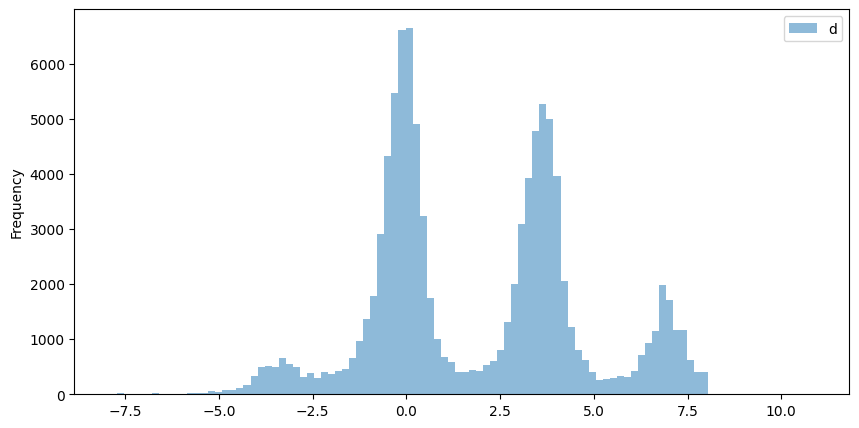

In [19]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 5))

joined_df.filter(pl.col("lane").str.contains("W"))[["d"]].sample(
    100_000
).to_pandas().plot.hist(bins=100, ax=ax, alpha=0.5)

# set the range of the x-axis to be the same
# ax.set_xlim(-6, 10)
# radar_df["d"].to_pandas().plot.hist(bins=100, ax=ax, alpha=0.5)

<Axes: ylabel='Frequency'>

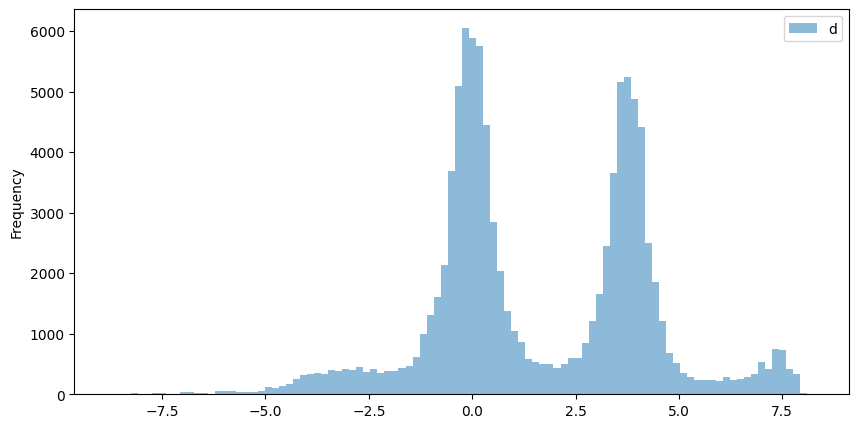

In [20]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 5))

joined_df.filter(pl.col("lane").str.contains("E"))[["d"]].sample(
    100_000
).to_pandas().plot.hist(bins=100, ax=ax, alpha=0.5)

# set the range of the x-axis to be the same
# ax.set_xlim(-6, 10)
# radar_df["d"].to_pandas().plot.hist(bins=100, ax=ax, alpha=0.5)

### Classify the Lanes


In [21]:
from src.pipelines.lane_classification import label_lane, label_lanes_tree
from src.gmm.lane_classification import build_lane_model
from src.plotting.lane_gmm import plot_model

In [22]:
joined_df = joined_df.pipe(
    label_lanes_tree,
    full_network=full_net,
    kalman_network=mainline_net,
    lane_width=LANE_WIDTH,
).filter(pl.col("lane_index").is_not_null())

## Merge the Trajectories


In [23]:
from src.pipelines.association import build_leader_follower_df, add_front_back_s

lf_df = (
    joined_df.lazy()
    .pipe(add_front_back_s, use_median_length=False)
    .pipe(build_leader_follower_df)
    # only consider vehicles that are fairly close
    .filter(pl.col("s_gap") < 30)
    # don't keep matches that are both prediction
    .filter(~(pl.col("prediction") & pl.col("prediction_leader")))
    # .filter()
    # assumption that radar tracks perfectly
    # .filter(pl.col("ip") != pl.col("ip_leader"))
    .filter(pl.col("s_velocity") > 5)
    .collect()
)

function: add_front_back_s took: 0.0002110004425048828 seconds
function: lazy_func took: 0.0016069412231445312 seconds


In [24]:
lf_df.head()

shape: (5, 24)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ object_id ┆ epoch_tim ┆ lane_hash ┆ leader    ┆ … ┆ P_leader  ┆ predictio ┆ ip_leader ┆ s_gap    │
│ ---       ┆ e         ┆ ---       ┆ ---       ┆   ┆ ---       ┆ n_leader  ┆ ---       ┆ ---      │
│ u64       ┆ ---       ┆ u64       ┆ u64       ┆   ┆ array[f32 ┆ ---       ┆ str       ┆ f32      │
│           ┆ datetime[ ┆           ┆           ┆   ┆ , 36]     ┆ bool      ┆           ┆          │
│           ┆ ms, UTC]  ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ 182220357 ┆ 2023-10-3 ┆ 140855276 ┆ 880544524 ┆ … ┆ [3.846154 ┆ false     ┆ 10.160.7. ┆ 8.485596 │
│ 753212756 ┆ 1 16:45:0 ┆ 355311033 ┆ 969998276 ┆   ┆ , 2.9104e ┆           ┆ 146       ┆          │
│ 68        ┆ 5.600 UTC ┆ 17        ┆ 4         ┆   ┆ -11, …    ┆           ┆           ┆          │
│           ┆           ┆           ┆           ┆   ┆ 100.0]    ┆           ┆           ┆          │
│ 182220357 ┆ 2023-10-3 ┆ 140855276 ┆ 880544524 ┆ … ┆ [1.962077 ┆ false     ┆ 10.160.7. ┆ 8.513062 │
│ 753212756 ┆ 1 16:45:0 ┆ 355311033 ┆ 969998276 ┆   ┆ ,         ┆           ┆ 146       ┆          │
│ 68        ┆ 5.700 UTC ┆ 17        ┆ 4         ┆   ┆ 0.025372, ┆           ┆           ┆          │
│           ┆           ┆           ┆           ┆   ┆ … 22.6189 ┆           ┆           ┆          │
│           ┆           ┆           ┆           ┆   ┆ 12…       ┆           ┆           ┆          │
│ 182220357 ┆ 2023-10-3 ┆ 140855276 ┆ 880544524 ┆ … ┆ [1.319261 ┆ false     ┆ 10.160.7. ┆ 8.455627 │
│ 753212756 ┆ 1 16:45:0 ┆ 355311033 ┆ 969998276 ┆   ┆ ,         ┆           ┆ 146       ┆          │
│ 68        ┆ 5.800 UTC ┆ 17        ┆ 4         ┆   ┆ 0.036886, ┆           ┆           ┆          │
│           ┆           ┆           ┆           ┆   ┆ … 11.1097 ┆           ┆           ┆          │
│           ┆           ┆           ┆           ┆   ┆ 33…       ┆           ┆           ┆          │
│ 182220357 ┆ 2023-10-3 ┆ 140855276 ┆ 880544524 ┆ … ┆ [0.996132 ┆ false     ┆ 10.160.7. ┆ 8.329224 │
│ 753212756 ┆ 1 16:45:0 ┆ 355311033 ┆ 969998276 ┆   ┆ ,         ┆           ┆ 146       ┆          │
│ 68        ┆ 5.900 UTC ┆ 17        ┆ 4         ┆   ┆ 0.046129, ┆           ┆           ┆          │
│           ┆           ┆           ┆           ┆   ┆ …         ┆           ┆           ┆          │
│           ┆           ┆           ┆           ┆   ┆ 8.607573] ┆           ┆           ┆          │
│ 182220357 ┆ 2023-10-3 ┆ 140855276 ┆ 880544524 ┆ … ┆ [0.802525 ┆ false     ┆ 10.160.7. ┆ 8.164978 │
│ 753212756 ┆ 1         ┆ 355311033 ┆ 969998276 ┆   ┆ ,         ┆           ┆ 146       ┆          │
│ 68        ┆ 16:45:06  ┆ 17        ┆ 4         ┆   ┆ 0.054514, ┆           ┆           ┆          │
│           ┆ UTC       ┆           ┆           ┆   ┆ …         ┆           ┆           ┆          │
│           ┆           ┆           ┆           ┆   ┆ 7.30653]  ┆           ┆           ┆          │
└───────────┴───────────┴───────────┴───────────┴───┴───────────┴───────────┴───────────┴──────────┘

### Calculate the Association Log-Likelihood Distance


In [25]:
from src.pipelines.association import calc_assoc_liklihood_distance

lf_df = lf_df.pipe(
    calc_assoc_liklihood_distance,
    gpu=False,
)

function: lazy_func took: 1.8892138004302979 seconds


### Calculate the Match Indexes


In [26]:
from scipy.stats import chi
from src.pipelines.association import (
    calculate_match_indexes,
    pipe_gate_headway_calc,
    build_match_df,
)

match_df = (
    lf_df.pipe(calculate_match_indexes, match_time_threshold=0.5)
    .pipe(pipe_gate_headway_calc)
    .pipe(
        build_match_df,
        traj_time_df=joined_df.group_by("object_id")
        .agg(
            pl.col("epoch_time").max().alias("epoch_time_max"),
        )
        .lazy(),
        assoc_cutoff=chi.ppf(0.995, 4),
        assoc_cutoff_pred=chi.ppf(0.99, 4),
    )
    .collect()
)

function: lazy_func took: 0.03063178062438965 seconds
function: lazy_func took: 0.0017669200897216797 seconds
function: lazy_func took: 0.32375288009643555 seconds


### Re-Label the Joined Trajectories


In [27]:
from src.pipelines.association import create_vehicle_ids

assoc_df = joined_df.pipe(
    create_vehicle_ids,
    match_df,
)

function: lazy_func took: 1.341538667678833 seconds


In [28]:
veh_df[["sequence_id", "name"]].unique().join(
    veh_df["sequence_id"].value_counts(),
    on="sequence_id",
).filter(pl.col("counts") > 100).sort(
    "counts",
)

shape: (10, 3)
┌─────────────┬──────┬────────┐
│ sequence_id ┆ name ┆ counts │
│ ---         ┆ ---  ┆ ---    │
│ u32         ┆ str  ┆ u32    │
╞═════════════╪══════╪════════╡
│ 6           ┆ EBL1 ┆ 156    │
│ 4           ┆ WBL1 ┆ 236    │
│ 10          ┆ WBL2 ┆ 379    │
│ 5           ┆ WBL1 ┆ 431    │
│ …           ┆ …    ┆ …      │
│ 22          ┆ WBL1 ┆ 999    │
│ 19          ┆ WBL2 ┆ 1061   │
│ 23          ┆ EBL2 ┆ 1199   │
│ 20          ┆ EBL1 ┆ 1243   │
└─────────────┴──────┴────────┘

In [29]:
drive_df = veh_df.filter((pl.col("sequence_id") == 20))

drive_df = drive_df.pipe(
    radar_obj.add_cst_timezone, time_col="gps_time", cst_col="cst_time"
)
drive_df["name"][0]
# drive_df[["lat", "lon", "gps_time"]].write_csv(ROOT / "data" / "drive.csv")

function: add_cst_timezone took: 0.008113861083984375 seconds


'EBL1'

In [30]:
import plotly.graph_objects as go
from src.plotting.time_space import plot_time_space
from datetime import timedelta


max_s = drive_df["s"].max()

fig = go.Figure()


for g, seq_df in drive_df.group_by("sequence_id"):
    fig.add_trace(
        go.Scatter(
            x=(seq_df["cst_time"] - timedelta(seconds=15.5)).cast(str),
            y=seq_df["s"],
            mode="markers+lines",
            name=f"Sequence {g}",
            marker_color="black",
        ),
    )


# get a 10 minute window
plot_df = (
    assoc_df.with_columns((pl.col("s")).alias("s"))
    .filter(
        pl.col("epoch_time").is_between(
            drive_df["gps_time"].min() - timedelta(hours=0, seconds=50),
            drive_df["gps_time"].max() + timedelta(hours=0, seconds=0),
        )
        & (pl.col("lane").str.contains("E"))
        & (pl.col("lane_index") == 0)
    )
    .pipe(radar_obj.add_cst_timezone)
    # .filter(pl.col("vehicle_id") == 886)
)

fig = plot_time_space(
    plot_df,
    hoverdata="object_id",
    vehicle_col="vehicle_id",
    s_col="s",
    markers=True,
    fig=fig,
)


# if SHOW_FIGS:
fig.show()

function: add_cst_timezone took: 0.00037789344787597656 seconds


/Users/max/Development/DOE-Project/roadside-radar/src/plotting/time_space.py:39: FutureWarning:

In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.



## Fuse & Smooth the Trajectories


In [31]:
from src.pipelines.association import build_fusion_df

fusion_df = (
    assoc_df.pipe(build_fusion_df, speed_threshold=5)
    .collect(streaming=True)
    .pipe(
        radar_obj.add_cst_timezone,
        time_col="epoch_time",
    )
)

fusion_df.head()

function: lazy_func took: 19.749789237976074 seconds
function: add_cst_timezone took: 0.05158710479736328 seconds


shape: (5, 65)
┌─────────────┬────────────┬─────────┬──────────┬───┬──────────┬───────┬────────────┬──────────────┐
│ s           ┆ s_velocity ┆ s_accel ┆ d        ┆ … ┆ cumcount ┆ count ┆ time_index ┆ vehicle_time │
│ ---         ┆ ---        ┆ ---     ┆ ---      ┆   ┆ ---      ┆ ---   ┆ ---        ┆ _index_int   │
│ f32         ┆ f32        ┆ f32     ┆ f32      ┆   ┆ u32      ┆ u32   ┆ u32        ┆ ---          │
│             ┆            ┆         ┆          ┆   ┆          ┆       ┆            ┆ u32          │
╞═════════════╪════════════╪═════════╪══════════╪═══╪══════════╪═══════╪════════════╪══════════════╡
│ 875.403625  ┆ 6.804616   ┆ 0.0     ┆ 4.063406 ┆ … ┆ 0        ┆ 1     ┆ 0          ┆ 0            │
│ 940.203857  ┆ 13.876619  ┆ 0.0     ┆ 3.545583 ┆ … ┆ 0        ┆ 1     ┆ 0          ┆ 0            │
│ 947.095886  ┆ 14.299694  ┆ 0.0     ┆ 0.163479 ┆ … ┆ 0        ┆ 1     ┆ 0          ┆ 0            │
│ 538.197632  ┆ 13.871054  ┆ 0.0     ┆ 3.882576 ┆ … ┆ 0        ┆ 1     ┆ 0          ┆ 0            │
│ 1209.705078 ┆ 0.0        ┆ 0.0     ┆ 3.509531 ┆ … ┆ 0        ┆ 1     ┆ 0          ┆ 0            │
└─────────────┴────────────┴─────────┴──────────┴───┴──────────┴───────┴────────────┴──────────────┘

In [32]:
from src.filters.fusion import batch_join, rts_smooth

merged_df = batch_join(fusion_df, method="IMF", batch_size=200, gpu=False)
merged_df = rts_smooth(merged_df, batch_size=200, gpu=False)

# # trim the last 4 seconds of all trajectories
# merged_df = merged_df.filter(
#     ((pl.col('epoch_time').max() - pl.col('epoch_time')) > timedelta(seconds=4)).over('vehicle_id')
# )

100%|██████████| 166/166 [00:00<00:00, 398.59it/s]
/Users/max/Development/DOE-Project/roadside-radar/src/filters/fusion.py:633: UserWarning:

The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_numpy.cpp:212.)

100%|██████████| 1031/1031 [00:00<00:00, 1152.16it/s]


In [33]:
merged_df.drop(
    [c for c in merged_df.columns if ("ci_" in c) or ("_int" in c)]
).write_parquet(
    ROOT / "data" / "merged.parquet",
    use_pyarrow=True,
    compression="zstd",
    compression_level=15,
)

In [34]:
import plotly.graph_objects as go
from src.plotting.time_space import plot_time_space
from datetime import timedelta


max_s = drive_df["s"].max()


# get a 10 minute window
plot_df = (
    merged_df.with_columns(pl.col("s_smooth").alias("s"))
    .filter(
        pl.col("epoch_time").is_between(
            drive_df["gps_time"].min() - timedelta(hours=0, seconds=30),
            drive_df["gps_time"].max() + timedelta(hours=0, seconds=30),
        )
        & (pl.col("lane").str.contains("E"))
        & (pl.col("lane_index") == 1)
    )
    .pipe(radar_obj.add_cst_timezone)
)

fig = plot_time_space(
    plot_df,
    hoverdata="vehicle_id",
    vehicle_col="vehicle_id",
    s_col="s",
    markers=True,
)


for g, seq_df in drive_df.group_by("sequence_id"):
    fig.add_trace(
        go.Scatter(
            x=(seq_df["cst_time"] - timedelta(seconds=15.5)).cast(str),
            y=seq_df["s"],
            mode="markers+lines",
            name=f"Sequence {g}",
            marker_color="black",
        ),
    )

if SHOW_FIGS:
    fig.show()

function: add_cst_timezone took: 0.0008778572082519531 seconds


/Users/max/Development/DOE-Project/roadside-radar/src/plotting/time_space.py:39: FutureWarning:

In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.



In [35]:
# fusion_df.filter(pl.col("vehicle_id") == 886).filter(
#     (pl.count() > 2).over('epoch_time_cst')
# )

In [36]:
from src.plotting.single_veh import plot_vehicle

# 2370	22	2.326786	0.303536	"1"
# 1227	22	6.57618	1.667884	"1"
# 1209
vehs = [
    1178,
    1219,
    1506,
    1209
    # 1098,
]

fig = None

drive_df = veh_df.filter((pl.col("sequence_id") == 20)).pipe(
    radar_obj.add_cst_timezone, time_col="gps_time", cst_col="cst_time"
)

for veh in vehs:
    ind_vehicles = (
        fusion_df.filter(pl.col("vehicle_id") == veh)["object_id"].unique().to_list()
    )

    fig = plot_vehicle(
        fusion_df.filter(pl.col("vehicle_id") == veh),
        s_velocity_col="f32_velocityInDir_mps",
        fig=fig,
    )

    plot_vehicle(
        merged_df.filter(pl.col("vehicle_id") == veh).pipe(radar_obj.add_cst_timezone),
        # s_col="s_smooth",
        s_col="s_smooth",
        s_velocity_col="s_velocity_smooth",
        # s_velocity_col="ci_s_velocity",
        d_col="d_smooth",
        d_velocity_col="d_velocity_smooth",
        fig=fig,
        color="blue",
    )

    plot_vehicle(
        radar_df.filter(
            pl.col("object_id").is_in(
                assoc_df.filter(pl.col("vehicle_id") == veh)["object_id"]
            )
        ).pipe(
            radar_obj.add_cst_timezone,
        ),
        s_col="s",
        # s_velocity_col="s_velocity",
        d_col="d",
        # d_velocity_col="d_velocity",
        fig=fig,
        color="black",
    )


plot_vehicle(
    drive_df.with_columns(
        pl.col("speed").alias("s_velocity"),
        (
            pl.col("d").diff()
            / (pl.col("gps_time").diff().dt.total_milliseconds() / 1e3)
        ).alias("d_velocity"),
        pl.col("gps_time") - timedelta(seconds=15.5),
        (pl.col("d") + 3.55),
    ).pipe(
        radar_obj.add_cst_timezone,
        time_col="gps_time",
    ),
    color="green",
    fig=fig,
)

fig.update_layout(
    height=800,
    width=1200,
)

function: add_cst_timezone took: 0.0008699893951416016 seconds
function: add_cst_timezone took: 0.00010013580322265625 seconds
function: add_cst_timezone took: 0.00013685226440429688 seconds
function: add_cst_timezone took: 5.626678466796875e-05 seconds
function: add_cst_timezone took: 0.0001010894775390625 seconds
function: add_cst_timezone took: 5.984306335449219e-05 seconds
function: add_cst_timezone took: 9.822845458984375e-05 seconds
function: add_cst_timezone took: 8.893013000488281e-05 seconds
function: add_cst_timezone took: 9.393692016601562e-05 seconds
function: add_cst_timezone took: 6.008148193359375e-05 seconds


## Calculate Error


In [37]:
veh_df = veh_df.with_columns(
    (pl.col("name").str.slice(-1, 1).cast(pl.UInt16) - 1).alias("lane_index"),
    pl.concat_str(pl.col("name").str.slice(0, 3), pl.lit("1")).alias("lane"),
    pl.col("gps_time").cast(merged_df["epoch_time"].dtype).alias("epoch_time"),
)

veh_df = veh_df.filter(pl.count().over("sequence_id") > 50)

In [38]:
error_summary = []

for second_offset in range(0, 600, 1):
    error_df = (
        veh_df.with_columns(
            pl.col("epoch_time") - timedelta(seconds=second_offset / 10),
        )
        .filter(pl.col("epoch_time").is_in(merged_df["epoch_time"].unique()))
        .sort("s")
        .set_sorted("s")
        .join(
            merged_df.select(
                [
                    "s_smooth",
                    "s_velocity_smooth",
                    "epoch_time",
                    "vehicle_id",
                    "lane",
                    "lane_index",
                ]
            ),
            on=["epoch_time", "lane", "lane_index"],
            # how="outer",
        )
        .with_columns(
            # calculate the rms error
            ((pl.col("s") - pl.col("s_smooth")) ** 2).alias("s_squared_error"),
            ((pl.col("speed") - pl.col("s_velocity_smooth")) ** 2).alias(
                "s_velocity_squared_error"
            ),
        )
        .group_by(["vehicle_id", "sequence_id"])
        .agg(
            (pl.col("s_squared_error").sum() / pl.count()).sqrt().alias("s_rmse"),
            (pl.col("s_velocity_squared_error").sum() / pl.count())
            .sqrt()
            .alias("s_velocity_rmse"),
        )
        .group_by("sequence_id")
        .agg(
            pl.col("vehicle_id")
            .gather(pl.col("s_rmse").arg_min())
            .alias("min_rmse_vehicle_id"),
            pl.col("vehicle_id")
            .gather(pl.col("s_velocity_rmse").arg_min())
            .alias("min_s_velocity_rmse_vehicle_id"),
            pl.col("s_rmse").min().alias("min_rmse"),
            pl.col("s_velocity_rmse").min().alias("min_s_velocity_rmse"),
        )
        .explode(["min_rmse_vehicle_id", "min_s_velocity_rmse_vehicle_id"])
    )

    error_summary.append(
        error_df.with_columns(
            pl.lit(second_offset / 10).alias("second_offset"),
        )
    )

In [39]:
from plotly.subplots import make_subplots

error_summary_df = pl.concat(error_summary)

error_summary_df_seconds = error_summary_df.group_by("second_offset").agg(
    pl.col("min_rmse").mean().alias("min_rmse"),
    pl.col("min_s_velocity_rmse").mean().alias("min_s_velocity_rmse"),
)

fig = make_subplots(specs=[[{"secondary_y": True}]])

fig.add_trace(
    go.Scatter(
        x=error_summary_df_seconds["second_offset"],
        y=error_summary_df_seconds["min_rmse"],
        name="RMSE",
    )
)

fig.add_trace(
    go.Scatter(
        x=error_summary_df_seconds["second_offset"],
        y=error_summary_df_seconds["min_s_velocity_rmse"],
        name="Speed RMSE",
    ),
    secondary_y=True,
)

fig.update_layout(
    height=800,
    width=1200,
    xaxis_title="Second Offset",
    yaxis_title="RMSE",
    yaxis2_title="Speed RMSE",
)

### Implement the Offset and Try to Cluster the Matching Vehicles


In [40]:
optimal_offset = error_summary_df_seconds.sort("min_rmse")["second_offset"][0]

print(f"Optimal offset: {optimal_offset}")

Optimal offset: 15.6


In [41]:
scatter_df = (
    veh_df.with_columns(
        pl.col("epoch_time") - timedelta(seconds=optimal_offset),
    )
    .filter(pl.col("epoch_time").is_in(merged_df["epoch_time"].unique()))
    .sort("s")
    .set_sorted("s")
    .join(
        merged_df.select(
            [
                "s_smooth",
                "s_velocity_smooth",
                "epoch_time",
                "vehicle_id",
                "lane",
                "lane_index",
            ]
        ),
        on=["epoch_time", "lane", "lane_index"],
        # how="outer",
    )
    .with_columns(
        # calculate the rms error
        ((pl.col("s") - pl.col("s_smooth")) ** 2).alias("s_squared_error"),
        ((pl.col("speed") - pl.col("s_velocity_smooth")) ** 2).alias(
            "s_velocity_squared_error"
        ),
    )
    .group_by(["vehicle_id", "sequence_id"])
    .agg(
        (pl.col("s_squared_error").sum() / pl.count()).sqrt().alias("s_rmse"),
        (pl.col("s_velocity_squared_error").sum() / pl.count())
        .sqrt()
        .alias("s_velocity_rmse"),
    )
)

In [42]:
# try to make two clusters
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=2).fit(scatter_df[["s_rmse", "s_velocity_rmse"]].to_numpy())

scatter_df = scatter_df.with_columns(
    cluster=pl.Series(dbscan.labels_).cast(str),
)

In [43]:
import plotly.express as px


fig = px.scatter(
    scatter_df.to_pandas(),
    x="s_rmse",
    y="s_velocity_rmse",
    color="cluster",
    hover_data=["vehicle_id", "sequence_id"],
)

fig.show()

In [44]:
good_matches = scatter_df.filter(pl.col("cluster") == "0")

In [45]:
object_ids = fusion_df.filter(
    pl.col("vehicle_id").is_in(good_matches["vehicle_id"].unique().to_list())
)[["vehicle_id", "object_id"]].unique()

In [46]:
raw_error_df = (
    radar_df.filter(
        pl.col("object_id").is_in(object_ids["object_id"]) & ~pl.col("prediction")
    )
    .pipe(label_lane, right_lane_center=0, lane_width=3.55)
    .join(
        object_ids,
        on="object_id",
    )
)

# raw_error_df.head()

function: label_lane took: 0.008527755737304688 seconds


In [47]:
paired_df = (
    veh_df.with_columns(
        pl.col("epoch_time") - timedelta(seconds=optimal_offset),
    )
    .sort("s")
    .set_sorted("s")
    .join(
        merged_df.select(
            [
                "s_smooth",
                "d_smooth",
                "s_velocity_smooth",
                "d_velocity_smooth",
                "epoch_time",
                "vehicle_id",
                "lane",
                "lane_index",
                # "vehicle_id"
            ]
        )
        .with_columns(
            (pl.col("s_velocity_smooth") ** 2 + pl.col("d_velocity_smooth") ** 2)
            .sqrt()
            .alias("speed_smooth"),
        )
        .filter(pl.col("vehicle_id").is_in(good_matches["vehicle_id"])),
        on=[
            "epoch_time",
            "lane",
        ],
        how="left",
    )
    .join(
        raw_error_df.select(
            "epoch_time",
            pl.col("s").alias("s_raw"),
            "ip",
            "object_id",
            "vehicle_id",
            pl.col("f32_velocityInDir_mps").alias("speed_raw"),
            pl.col("utm_x").alias("x_raw"),
            pl.col("utm_y").alias("y_raw"),
            pl.col("f32_distanceToBack_m").alias("back_dist"),
            pl.col("f32_distanceToFront_m").alias("front_dist"),
        ),
        on=["epoch_time", "vehicle_id"],
        how="left",
    )
)

paired_df.head()

shape: (5, 35)
┌───────┬────────────────────┬───────────┬────────────┬───┬───────┬───────┬───────────┬────────────┐
│ seq   ┆ gps_time           ┆ lat       ┆ lon        ┆ … ┆ x_raw ┆ y_raw ┆ back_dist ┆ front_dist │
│ ---   ┆ ---                ┆ ---       ┆ ---        ┆   ┆ ---   ┆ ---   ┆ ---       ┆ ---        │
│ u32   ┆ datetime[μs, UTC]  ┆ f64       ┆ f64        ┆   ┆ f64   ┆ f64   ┆ f32       ┆ f32        │
╞═══════╪════════════════════╪═══════════╪════════════╪═══╪═══════╪═══════╪═══════════╪════════════╡
│ 12835 ┆ 2023-10-31         ┆ 33.236931 ┆ -87.605733 ┆ … ┆ null  ┆ null  ┆ null      ┆ null       │
│       ┆ 17:06:09.800 UTC   ┆           ┆            ┆   ┆       ┆       ┆           ┆            │
│ 12836 ┆ 2023-10-31         ┆ 33.236926 ┆ -87.605755 ┆ … ┆ null  ┆ null  ┆ null      ┆ null       │
│       ┆ 17:06:09.900 UTC   ┆           ┆            ┆   ┆       ┆       ┆           ┆            │
│ 16824 ┆ 2023-10-31         ┆ 33.236961 ┆ -87.605749 ┆ … ┆ null  ┆ null  ┆ null      ┆ null       │
│       ┆ 17:13:00.900 UTC   ┆           ┆            ┆   ┆       ┆       ┆           ┆            │
│ 16825 ┆ 2023-10-31         ┆ 33.236956 ┆ -87.605771 ┆ … ┆ null  ┆ null  ┆ null      ┆ null       │
│       ┆ 17:13:01 UTC       ┆           ┆            ┆   ┆       ┆       ┆           ┆            │
│ 7926  ┆ 2023-10-31         ┆ 33.23278  ┆ -87.623233 ┆ … ┆ null  ┆ null  ┆ null      ┆ null       │
│       ┆ 16:57:34.800 UTC   ┆           ┆            ┆   ┆       ┆       ┆           ┆            │
└───────┴────────────────────┴───────────┴────────────┴───┴───────┴───────┴───────────┴────────────┘

In [48]:
paired_df = network.frenet2xy(
    paired_df.drop("x_lane", "y_lane"),
    lane_col="lane",
    s_col="s_smooth",
    d_col="d_smooth",
).pipe(
    radar_obj.radar_to_latlon,
    utm_x_col="x_lane",
    utm_y_col="y_lane",
    lat_col="lat_lane",
    lon_col="lon_lane",
)

# paired_df.write_csv(ROOT / "data" / "radar_lane.csv")

function: radar_to_latlon took: 0.012293100357055664 seconds


In [49]:
paired_df.head()

shape: (5, 39)
┌───────┬──────────────┬───────────┬────────────┬───┬────────┬────────────┬──────────┬──────────┐
│ seq   ┆ gps_time     ┆ lat       ┆ lon        ┆ … ┆ s_lane ┆ angle_lane ┆ lat_lane ┆ lon_lane │
│ ---   ┆ ---          ┆ ---       ┆ ---        ┆   ┆ ---    ┆ ---        ┆ ---      ┆ ---      │
│ u32   ┆ datetime[μs, ┆ f64       ┆ f64        ┆   ┆ f64    ┆ f64        ┆ f64      ┆ f64      │
│       ┆ UTC]         ┆           ┆            ┆   ┆        ┆            ┆          ┆          │
╞═══════╪══════════════╪═══════════╪════════════╪═══╪════════╪════════════╪══════════╪══════════╡
│ 7926  ┆ 2023-10-31   ┆ 33.23278  ┆ -87.623233 ┆ … ┆ null   ┆ null       ┆ null     ┆ null     │
│       ┆ 16:57:34.800 ┆           ┆            ┆   ┆        ┆            ┆          ┆          │
│       ┆ UTC          ┆           ┆            ┆   ┆        ┆            ┆          ┆          │
│ 7927  ┆ 2023-10-31   ┆ 33.232785 ┆ -87.623208 ┆ … ┆ null   ┆ null       ┆ null     ┆ null     │
│       ┆ 16:57:34.900 ┆           ┆            ┆   ┆        ┆            ┆          ┆          │
│       ┆ UTC          ┆           ┆            ┆   ┆        ┆            ┆          ┆          │
│ 18343 ┆ 2023-10-31   ┆ 33.232779 ┆ -87.623231 ┆ … ┆ null   ┆ null       ┆ null     ┆ null     │
│       ┆ 17:15:36.400 ┆           ┆            ┆   ┆        ┆            ┆          ┆          │
│       ┆ UTC          ┆           ┆            ┆   ┆        ┆            ┆          ┆          │
│ 18344 ┆ 2023-10-31   ┆ 33.232783 ┆ -87.62321  ┆ … ┆ null   ┆ null       ┆ null     ┆ null     │
│       ┆ 17:15:36.500 ┆           ┆            ┆   ┆        ┆            ┆          ┆          │
│       ┆ UTC          ┆           ┆            ┆   ┆        ┆            ┆          ┆          │
│ 4560  ┆ 2023-10-31   ┆ 33.232747 ┆ -87.623226 ┆ … ┆ null   ┆ null       ┆ null     ┆ null     │
│       ┆ 16:51:27.700 ┆           ┆            ┆   ┆        ┆            ┆          ┆          │
│       ┆ UTC          ┆           ┆            ┆   ┆        ┆            ┆          ┆          │
└───────┴──────────────┴───────────┴────────────┴───┴────────┴────────────┴──────────┴──────────┘

## Calculate the Error


In [50]:
import numpy as np
from scipy.stats import pearsonr


def se(df: pl.DataFrame, true_col: str, pred_col: str, out_col: str) -> pl.DataFrame:
    return df.with_columns(
        ((pl.col(true_col) - pl.col(pred_col)) ** 2).alias(out_col),
    )


def mse(df: pl.DataFrame, true_col: str, pred_col: str) -> float:
    return ((df[true_col].to_numpy() - df[pred_col].to_numpy()) ** 2).mean()


def rmse(df: pl.DataFrame, true_col: str, pred_col: str) -> float:
    return mse(df, true_col, pred_col) ** (1 / 2)


def pearsonr_(df: pl.DataFrame, true_col: str, pred_col: str) -> float:
    return pearsonr(df[true_col].to_numpy(), df[pred_col].to_numpy())[0]

In [51]:
error_df = paired_df.filter(pl.col("s_smooth").is_not_null())

rmse_s = error_df.unique(["vehicle_id", "epoch_time"]).pipe(
    rmse,
    true_col="s",
    pred_col="s_smooth",
)

rmse_raw = (
    error_df.filter(pl.col("s_raw").is_not_null())
    .unique(["object_id", "epoch_time"])
    .pipe(
        rmse,
        true_col="s",
        pred_col="s_raw",
    )
)

mse_s = error_df.unique(["vehicle_id", "epoch_time"]).pipe(
    mse,
    true_col="s",
    pred_col="s_smooth",
)

corr_s = error_df.unique(["vehicle_id", "epoch_time"]).pipe(
    pearsonr_,
    true_col="s",
    pred_col="s_smooth",
)

rmse_velocity = error_df.unique(["vehicle_id", "epoch_time"]).pipe(
    rmse,
    true_col="speed",
    pred_col="speed_smooth",
)

rmse_velocity_raw = (
    error_df.filter(pl.col("speed_raw").is_not_null())
    .unique(["object_id", "epoch_time"])
    .pipe(
        rmse,
        true_col="speed",
        pred_col="speed_raw",
    )
)

mse_velocity = error_df.pipe(
    mse,
    true_col="speed",
    pred_col="speed_smooth",
)

corr_velocity = error_df.pipe(
    pearsonr_,
    true_col="speed",
    pred_col="speed_smooth",
)

print(f"RMSE raw: {rmse_raw}, ")
print(f"RMSE: {rmse_s}, MSE: {mse_s}, Corr: {corr_s}")
print(f"RMSE velocity raw: {rmse_velocity_raw}, ")
print(f"Velocity RMSE: {rmse_velocity}, MSE: {mse_velocity}, Corr: {corr_velocity}")

RMSE raw: 3.0117499107132093, 
RMSE: 2.21424572025297, MSE: 4.9028841096585944, Corr: 0.999982625554094
RMSE velocity raw: 1.0693739603410641, 
Velocity RMSE: 0.5866696914419988, MSE: 0.394207603841306, Corr: 0.9919702398748905


In [52]:
rmse_s = error_df.unique(["vehicle_id", "epoch_time"]).pipe(
    rmse,
    true_col=["x", "y"],
    pred_col=["x_lane", "y_lane"],
)


rmse_raw = (
    error_df.filter(pl.col("s_raw").is_not_null())
    .unique(["object_id", "epoch_time"])
    .pipe(
        rmse,
        true_col=["x", "y"],
        pred_col=["x_raw", "y_raw"],
    )
)


mse_s = error_df.unique(["vehicle_id", "epoch_time"]).pipe(
    mse,
    true_col=["x", "y"],
    pred_col=["x_lane", "y_lane"],
)

mse_s_raw = (
    error_df.filter(pl.col("s_raw").is_not_null())
    .unique(["object_id", "epoch_time"])
    .pipe(
        mse,
        true_col=["x", "y"],
        pred_col=["x_raw", "y_raw"],
    )
)


rmse_velocity = error_df.unique(["vehicle_id", "epoch_time"]).pipe(
    rmse,
    true_col="speed",
    pred_col="speed_smooth",
)

mse_velocity = error_df.unique(["vehicle_id", "epoch_time"]).pipe(
    mse,
    true_col="speed",
    pred_col="speed_smooth",
)


print(f"RMSE raw: {rmse_raw}, MSE: {mse_s_raw}")
print(f"RMSE: {rmse_s}, MSE: {mse_s}")
print(f"Velocity RMSE: {rmse_velocity}, MSE: {mse_velocity}")

RMSE raw: 2.1708175422506377, MSE: 4.712448801743099
RMSE: 1.592549013126709, MSE: 2.5362123592108547
Velocity RMSE: 0.5866696914419988, MSE: 0.34418132685665004


### Error by S & Lane


In [53]:
import plotly.graph_objects as go

error_df = error_df.pipe(
    se,
    true_col="s",
    pred_col="s_smooth",
    out_col="s_squared_error",
)

# fig = go.Figure()

# for

In [54]:
agg_df = (
    error_df.with_columns((pl.col("s") // 5).cast(int))
    .sort("s")
    .group_by_dynamic("s", every="5i", by=["lane", "lane_index"])
    .agg(pl.col("s_squared_error").mean().alias("s_squared_error"))
    .with_columns(
        pl.col("s") * 5,
    )
)


fig = go.Figure()

for g, seq_df in agg_df.group_by("lane", "lane_index"):
    fig.add_trace(
        go.Scatter(
            x=seq_df["s"],
            y=seq_df["s_squared_error"],
            mode="markers+lines",
            name=f"Sequence {g}",
            # marker_color="black",
        ),
    )

if SHOW_FIGS:
    fig.show()

In [55]:
agg_df = (
    error_df.pipe(
        se,
        true_col="s",
        pred_col="s_smooth",
        out_col="s_squared_error",
    )
    .pipe(
        se,
        true_col="s",
        pred_col="s_raw",
        out_col="s_squared_error_raw",
    )
    .group_by("ip")
    .agg(
        pl.col("s_squared_error").mean().sqrt().alias("s_error"),
        pl.col("s_squared_error_raw").mean().sqrt().alias("s_error_raw"),
    )
)


fig = go.Figure()
# bar chart it
fig.add_trace(
    go.Bar(
        x=agg_df["ip"],
        y=agg_df["s_error"],
        name="Smoothed",
    ),
)

fig.add_trace(
    go.Bar(
        x=agg_df["ip"],
        y=agg_df["s_error_raw"],
        name="Raw",
    ),
)

fig.show()

In [56]:
import plotly.graph_objects as go


fig = go.Figure()

# plot all the EB trajectories
for g, seq_df in error_df.group_by("vehicle_id"):
    fig.add_trace(
        go.Scatter(
            x=seq_df["epoch_time"],
            y=seq_df["s"],
            mode="markers+lines",
            name=f"Sequence {g}",
            marker_color="black",
            showlegend=False,
        ),
    )

    fig.add_trace(
        go.Scatter(
            x=seq_df["epoch_time"],
            y=seq_df["s_smooth"],
            mode="markers+lines",
            name=f"Sequence {g}",
            marker_color="red",
            showlegend=False,
        ),
    )

    # plot the trajectories
    fig.add_trace(
        go.Scatter(
            x=seq_df["epoch_time"],
            y=seq_df["s_raw"],
            mode="markers",
            name=f"Sequence {g}",
            marker_color="green",
            showlegend=False,
        ),
    )

    # plot the trajectories
    fig.add_trace(
        go.Scatter(
            x=seq_df["epoch_time"],
            y=seq_df["s_raw"] + seq_df["back_dist"],
            mode="markers",
            name=f"Sequence {g}",
            marker_color="green",
            marker_symbol="triangle-up",
            showlegend=False,
        ),
    )

    fig.add_trace(
        go.Scatter(
            x=seq_df["epoch_time"],
            y=seq_df["s_raw"] + seq_df["front_dist"],
            mode="markers",
            name=f"Sequence {g}",
            marker_color="green",
            marker_symbol="triangle-down",
            showlegend=False,
        ),
    )

# if SHOW_FIGS:
fig.show()

## Comparing Aggregate Counts to Detector Data


In [57]:
import geopandas as gpd

d_df = gpd.read_file(ROOT / "data/detectors.geojson").to_crs(network._utm_crs)

network.get_intersections(d_df["geometry"][0])

shape: (2, 5)
┌───────────────┬──────────┬─────────────┬──────────┬──────┐
│ x             ┆ y        ┆ s           ┆ angle    ┆ lane │
│ ---           ┆ ---      ┆ ---         ┆ ---      ┆ ---  │
│ f64           ┆ f64      ┆ f64         ┆ f64      ┆ str  │
╞═══════════════╪══════════╪═════════════╪══════════╪══════╡
│ 442973.471283 ┆ 3.6775e6 ┆ 1074.29653  ┆ 0.263155 ┆ EBL2 │
│ 442974.435434 ┆ 3.6775e6 ┆ 1075.004375 ┆ 0.263764 ┆ EBL1 │
└───────────────┴──────────┴─────────────┴──────────┴──────┘

### Read in the Detector Counts


In [58]:
detector_df = (
    pl.scan_csv(ROOT / "data" / "tl_logs" / "10_31_2023.csv")
    .with_columns(
        pl.col("Timestamp")
        .str.strptime(
            pl.Datetime("ns", time_zone="US/Central"), format="%Y-%m-%d %H:%M:%S.%f"
        )
        .alias("epoch_time_cst"),
    )
    .with_columns(
        # pl.col('epoch_time_cst').dt.offset_by('1h')
        pl.col("epoch_time_cst")
        .dt.convert_time_zone("UTC")
        .alias("epoch_time")
    )
    .collect()
)

/var/folders/96/_9h8bqbx4gqcmb4td8q57q8w0000gn/T/ipykernel_79480/1277324360.py:4: ChronoFormatWarning:

Detected the pattern `.%f` in the chrono format string. This pattern should not be used to parse values after a decimal point. Use `%.f` instead. See the full specification: https://docs.rs/chrono/latest/chrono/format/strftime



In [60]:
import plotly.graph_objects as go
from src.plotting.time_space import plot_time_space
from datetime import timedelta


max_s = drive_df["s"].max()


drive_df = veh_df.filter((pl.col("sequence_id") == 23))

drive_df = drive_df.pipe(
    radar_obj.add_cst_timezone, time_col="gps_time", cst_col="cst_time"
)

# get a 10 minute window
plot_df = (
    merged_df.with_columns(pl.col("s_smooth").alias("s"))
    .filter(
        pl.col("epoch_time").is_between(
            drive_df["gps_time"].min() - timedelta(hours=0, minutes=1),
            drive_df["gps_time"].max() + timedelta(hours=0, minutes=1),
        )
        & (pl.col("lane").str.contains("E"))
        & (pl.col("lane_index") == 1)
    )
    .pipe(radar_obj.add_cst_timezone)
)

plot_detector_df = detector_df.filter(
    pl.col("epoch_time").is_between(
        drive_df["gps_time"].min() - timedelta(hours=0, minutes=1),
        drive_df["gps_time"].max() + timedelta(hours=0, minutes=1),
    )
    & pl.col("SignalID").str.ends_with("4")
    # & (pl.col('EventParam') == 10)
)


fig = plot_time_space(
    plot_df,
    hoverdata="vehicle_id",
    vehicle_col="vehicle_id",
    s_col="s",
    # markers=False,
)


for g, seq_df in drive_df.group_by("sequence_id"):
    fig.add_trace(
        go.Scatter(
            x=(seq_df["cst_time"] - timedelta(seconds=15.5)).cast(str),
            y=seq_df["s"],
            mode="lines",
            name=f"Sequence {g}",
            marker_color="black",
        ),
    )


fig.add_trace(
    go.Scatter(
        x=(plot_detector_df["epoch_time_cst"] + timedelta(seconds=2.8)).cast(str),
        y=[
            1075,
        ]
        * len(plot_detector_df),
        mode="markers",
        name=f"Sequence {g}",
        marker_color="black",
    ),
)

# if SHOW_FIGS:
fig.show()

function: add_cst_timezone took: 0.00019478797912597656 seconds
function: add_cst_timezone took: 0.0001418590545654297 seconds


/Users/max/Development/DOE-Project/roadside-radar/src/plotting/time_space.py:39: FutureWarning:

In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.



In [60]:
import plotly.graph_objects as go
from src.plotting.time_space import plot_time_space
from datetime import timedelta


max_s = drive_df["s"].max()

fig = go.Figure()

plot_detector_df = detector_df.filter(
    pl.col("epoch_time").is_between(
        drive_df["gps_time"].min() - timedelta(hours=0, minutes=1),
        drive_df["gps_time"].max() + timedelta(hours=0, minutes=1),
    )
    & pl.col("SignalID").str.ends_with("4")
    # & (pl.col('EventParam') == 10)
)


for g, seq_df in drive_df.group_by("sequence_id"):
    fig.add_trace(
        go.Scatter(
            x=(seq_df["cst_time"] - timedelta(seconds=15.5)).cast(str),
            y=max_s - seq_df["s"],
            mode="markers+lines",
            name=f"Sequence {g}",
            marker_color="black",
        ),
    )


# get a 10 minute window
plot_df = (
    assoc_df.with_columns((max_s - pl.col("s")).alias("s"))
    .filter(
        pl.col("epoch_time").is_between(
            drive_df["gps_time"].min() - timedelta(hours=0, seconds=30),
            drive_df["gps_time"].max() + timedelta(hours=0, seconds=30),
        )
        & (pl.col("lane").str.contains("E"))
        & (pl.col("lane_index") == 1)
    )
    .pipe(radar_obj.add_cst_timezone)
    # .filter(pl.col("vehicle_id") == 886)
)

fig = plot_time_space(
    plot_df,
    hoverdata="object_id",
    vehicle_col="vehicle_id",
    s_col="s",
    markers=True,
    fig=fig,
)

fig.add_trace(
    go.Scatter(
        x=(plot_detector_df["epoch_time_cst"] + timedelta(seconds=2.8)).cast(str),
        y=[
            max_s - 1075,
        ]
        * len(plot_detector_df),
        mode="markers",
        name=f"Sequence {g}",
        marker_color="black",
    ),
)


fig.show()

function: add_cst_timezone took: 0.00014281272888183594 seconds


/Users/max/Development/DOE-Project/roadside-radar/src/plotting/time_space.py:39: FutureWarning:

In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.



In [ ]:
plot_detector_df.head()